In [5]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, newton, Bounds
from scipy.stats import norm, lognorm, uniform, randint

# Problem Statement

>Due to difficulties in question creation, questions of level 1-3 is possible to be at least #15 questions. However, higher levels of 4-5, is it possible to reduce it to ~#8 questions?

Currently we have a total of 3 Trains; Reviews; CAT Test, so we need to test each situation.


## Trains

Trains uses the exam sampling type of `QUESTION_BANK`, which is predetermined ratio of questions in each level. These ratios are then sampled in `getNextDifficultyLevel`, where a random difficulty level is sampled according to the required question bank distribution. Errors relating to this consists of `Question list exhaustion`, which occurs when there is not enough questions with that **specific difficulty (b)** after `getNextDifficultyLevel`. The difficulty level after sampling is **fixed** and is not flexible. 

### Train 1

>The `QUESTION_BANK` is fixed, consisting of 15 questions in the pool, with _QDL 1: 7 Questions, QDL 2: 5 questions, QDL 3: 3 Questions_. A maximum of 10 questions will be administered in Train 1

There shouldn't be any problems with this since Levels 1-3 will have 15 questions, which are all > pool.

### Train 2

>The `QUESTION_BANK` is now sampled from the `clip(initialTraitLevelEstimate - 0.25)` (`getQBFromLevel`), consisting of 14 questions in the pool PER `lessonID` and `sectionID`: where the ratios are determined by the decimal of the `initialTraitLevelEstimate`. And after 7 questions, they will redo the incorrect questions until `testScore > 0.8`. 
>
>After checking further, Train 2 max questions PER lession & section is updated to 7 questions instead of 10 (per document).

There shouldn't be any problems with this because Train 2 is updated to have 7 questions maximum.

### Train 3

>The `QUESTION_BANK` is now sampled from the `clip(initialTraitLevelEstimate + 0.25)` (`getQBFromLevel`), consisting of 14 questions in the pool PER `selectedLessonID` and `selectedSectionID`: where the ratios are determined by the decimal of the `initialTraitLevelEstimate`. And after 7 questions, they will redo the incorrect questions until `testScore > 0.7`. 
>
>After checking further, Train 3 max questions PER lession & section is updated to 7 questions instead of 10 (per document).

There shouldn't be any problems with this because Train 3 is updated to have 7 questions maximum.

## CAT Test

>In the CAT test, the questions are queried by the relevant `lessonID` and `sectionID`, and sorted by Fisher Information of each question (the difficultly most corresponding to the user's trait level estimate). We administer the one with the highest information value. 

There shouldn't be any problems in question selection here since it's a soft selection with Fisher Information selection. However, there may be a problem with trait estimate convergence taking longer / results diverging, which we will attempt to examine further in our Monte Carlo experiment below.

In [129]:
def two_pl(a, b, t):
    """2PL Implementation (Vectorized). 
    N Students with K Test Items (Should not be the whole item pool!)
    Inputs: 
        a: Discrimination Parameter. Shape of (K,)
        b: Difficulty Parameter. Shape of (K,)
        t: Ability Level (Theta). Shape of (N,)
    Returns:
        Probability matrix of shape (K, N)
    """
    # If t is a matrix, do broadcasting, if not, just make it scalar
    if hasattr(t, '__len__') and (not isinstance(t, str)):
        tt = np.expand_dims(t, axis=1)
    else:
        tt = t
    return 1/(1 + np.exp(-1.7*a*(tt-b)))

In [130]:
def get_log_likelihood_f(a, b, u, minimization=True):
    """For a single student with latent trait theta.
    Note: May calculate the two_pl again, but I think it's worth it as a modular function
    Input:
        a: Discrimination Parameter. Shape of (K,)  Questions
        b: Difficulty Parameter. Shape of (K,) Questions
        u: vector correct u_i=1 correct, u_i=0 wrong. Shape of (K,) Reponses
        minimization: minimization problem or maximization problem
    Result:
        Function of log-likelihood suitable for optimization. with Input 
            theta: Latent trait theta. Shape of [1] ?
    """
    is_minimize = -1 if minimization else 1
    def log_likelihood(theta):
        p = np.squeeze(two_pl(a, b, theta)) # Returns shape of [K,1] -> [K,]
        return np.sum(u*np.log(p) + (1-u)*np.log(1-p))*is_minimize
    return log_likelihood

In [131]:
def fisher_information(a, b, t):
    p = np.squeeze(two_pl(a, b, t)) # Returns shape of [K,1] -> [K,]
    return 1.7**2 * np.square(a) * p * (1-p)

In [132]:
def get_d_log_likelihood_f(a, b, u):
    """For a single student with latent trait theta.
    Input:
        a: Discrimination Parameter. Shape of (K,)  Questions
        b: Difficulty Parameter. Shape of (K,) Questions
        u: vector correct u_i=1 correct, u_i=0 wrong. Shape of (K,) Reponses
    Result:
        Function of first derivative of log-likelihood suitable for optimization. with Input 
            theta: Latent trait theta. Shape of [1] ?
    """
    def d_log_likelihood(theta):
        p = np.squeeze(two_pl(a, b, theta)) # Returns shape of [K,1] -> [K,]
        return np.sum(1.7*a*(u-p))
    return d_log_likelihood

In [133]:
def get_dd_log_likelihood_f(a, b, u):
    """For a single student with latent trait theta.
    Input:
        a: Discrimination Parameter. Shape of (K,)  Questions
        b: Difficulty Parameter. Shape of (K,) Questions
        u: vector correct u_i=1 correct, u_i=0 wrong. Shape of (K,) Reponses
    Result:
        Function of second derivative of log-likelihood suitable for optimization. with Input 
            theta: Latent trait theta. Shape of [1] ?
    """
    def dd_log_likelihood(theta):  #This is just fisher_information with a negative sign!
        p = np.squeeze(two_pl(a, b, theta)) # Returns shape of [K,1] -> [K,]
        return - np.sum(1.7**2 * np.square(a) * p * (1-p))
    return dd_log_likelihood

# Monte Carlo Simulation - Experimental Setup

A Monte Carlo Simulation showing the difference between a full question bank and a partial question bank during CAT algorithm on the effects to latent trait estimate convergence. 

- K=240 Students with uniformly distributed latent trait levels $\hat{\theta} \in [-3,3]$ , which is $\pm 1$ from the difficulty parameter $b$ range
- Item question pool of 61 with (-2: 15, -1: 15, 0: 15, 1: 8, 2: 8) (Corresponding to Level 1-5)
- Seed will be varied between $[123,1234,12345]$
- Minimization Parameters of Newton-Rhapson algorithm
- Minimum number of Questions = 15
- Number of questions before optimizing = 5
- STANDARD_ERROR_THRESHOLD = 0.375
- STANDARD_ERROR_A = 1

In [134]:
# The Starting ability level (theta) of the test. 
# This can be either 2 or 3. Somewhere in the middle.
THETA_0 = 0
LEVELS = list(range(-2,3))

### For Monte Carlo Simulation ###
NUM_STUDENTS = 240

In [135]:
class QuestionParametersDistribution(object):
    """
    An object for generation Item Pool parameters.
    Will Generate a and b. With shape (2, ...size). Size = 61 = 15+15+15+8+8
    Fix a will fix A = 1.
    B will be fixed -2: 15, -1: 15, 0: 15, 1: 8, 2: 8 (Corresponding to Level 1-5)
    """
    def __init__(self, a_scale=1, b_low=-2, b_high=2, fix_a=True):
        self.a = randint(1, 2) if fix_a else lognorm(s=1., scale=a_scale)
        self.b = [-2]*15 + [-1]*15 + [0]*15 + [1]*8 + [2]*8
        
    def rvs(self, size=61, random_state=12):
        a = self.a.rvs(size, random_state=random_state)
        b = np.array(self.b)
        return [a,b]

In [136]:
question_dist = QuestionParametersDistribution()
questions = question_dist.rvs()
[question.shape for question in questions]

[(61,), (61,)]

Text(0.5, 0, 'b')

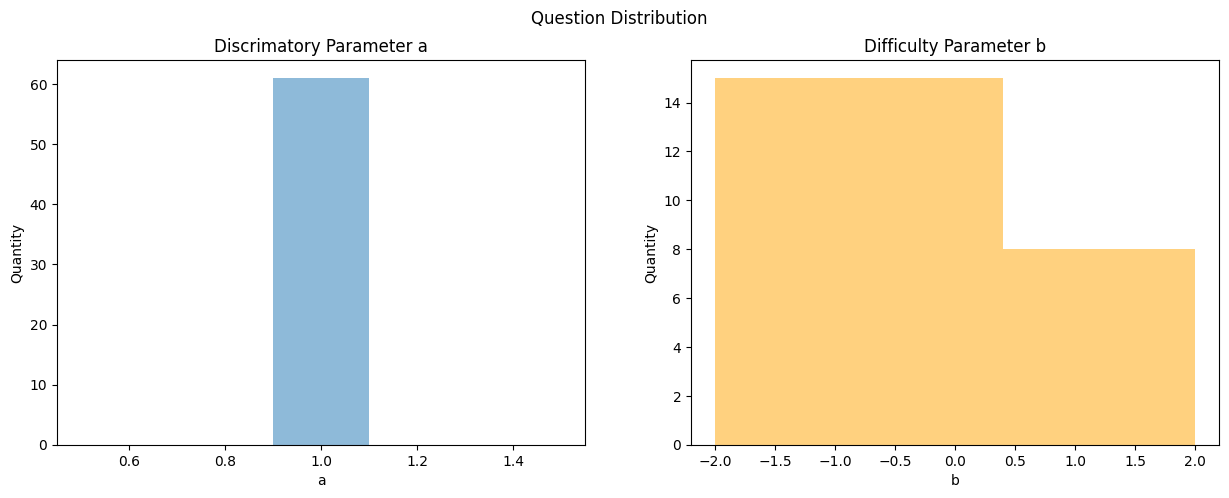

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Question Distribution')

ax1.hist(questions[0], bins=5, histtype='stepfilled', alpha=0.5)
ax1.set_title('Discrimatory Parameter a')
ax1.set_ylabel('Quantity')
ax1.set_xlabel('a')

ax2.hist(questions[1], bins=5, histtype='stepfilled', alpha=0.5, color='orange')
ax2.set_title('Difficulty Parameter b')
ax2.set_ylabel('Quantity')
ax2.set_xlabel('b')

In [153]:
class StudentParametersDistribution(object):
    """
    An object for generation and calculation of student parameters.
    In our context, we will uniformly generate Student Levels at -3 to +3  (+/- 1 out of range of the parameters)
    """
    def __init__(self, theta_low=-3, theta_high=3):
        self.theta = uniform(theta_low, theta_high-theta_low)

    def rvs(self, size=None, random_state=12, *args):
        return self.theta.rvs(size, random_state=random_state, *args)

    def logpdf(self, *args):
        return self.theta.logpdf(*args)

In [154]:
student_dist = StudentParametersDistribution()
students = student_dist.rvs(NUM_STUDENTS)
students.shape

(240,)

Text(0.5, 0, 'Latent Student Trait Level [θ]')

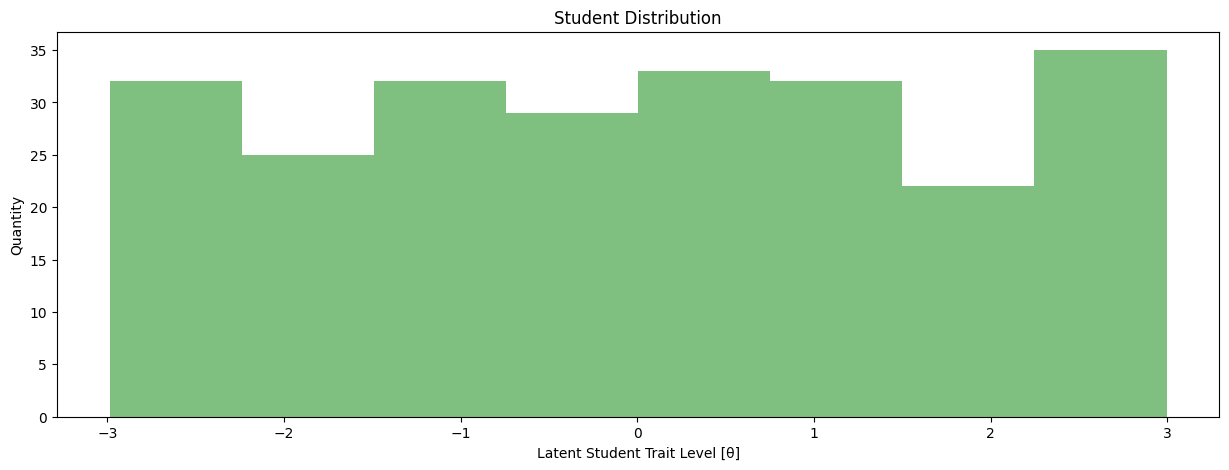

In [140]:
fig, ax = plt.subplots(1, figsize=(15,5))

ax.hist(students, bins=8, histtype='stepfilled', alpha=0.5, color='green')
ax.set_title('Student Distribution')
ax.set_ylabel('Quantity')
ax.set_xlabel('Latent Student Trait Level [θ]')

In [155]:
a,b = questions
theta = students

# Returns shape of [K,N]  (Students,Questions)
probability_matrix = two_pl(a,b,theta)
# Make Binomial Sampling with n=1 trial and p=probability matrix
answers = np.random.binomial(1, probability_matrix)
answers.shape # Will have shape of (Students, Questions)

(240, 61)

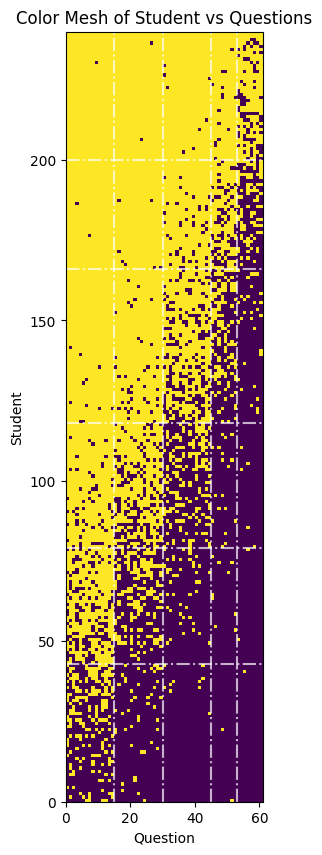

In [142]:
FIG_SIZE_MAX = 10
SCALE_MAX = max(answers.shape)
fig, ax = plt.subplots(1, figsize=(FIG_SIZE_MAX*answers.shape[1]/SCALE_MAX,FIG_SIZE_MAX*answers.shape[0]/SCALE_MAX))

# Sort by question difficulty and student ability
answer_plot = answers
answer_plot = answers[np.argsort(theta), ...]
answer_plot = answer_plot[..., np.argsort(b)]

ax.pcolormesh(answer_plot, cmap='viridis')
ax.set_title('Color Mesh of Student vs Questions')
ax.set_ylabel('Student')
ax.set_xlabel('Question')

# Draw Section lines for question difficulty 
for level in LEVELS:
    b_sorted = np.sort(b)
    question_index = min(np.where(b_sorted == level)[0]) # np.where returns both row and column indices
    ax.axvline(question_index, linestyle='-.', color='white', alpha=0.7)

# Draw Section lines for student ability 
for level in range(-2, 3):
    theta_sorted = np.sort(theta)
    student_index = min(np.where(theta_sorted >= level)[0])
    ax.axhline(student_index, linestyle='-.', color='white', alpha=0.7)

# Scenario 1: Sampling with Replacement (Unlimited # of Q)

In [143]:
%%time
# Newton-Rhapson
MIN_Q_COUNT = 15
Q_START = 5 # The number of questions before starting optimize more than 1 iter

# This should be an object of a_list, b_list, u_list, theta_list, niter_list, se_list, converge_list
# [Scalar]: theta_final, theta_real, se_final, mae, q_count, seed
result_list = []

# For all Students
for theta_real in theta:
    # For all Seeds
    for seed in [123,1234,12345]:
        rng = np.random.default_rng(seed)
        
        t = 0
        q_count = 0
        std_err = 100

        a_list = np.array([])
        b_list = np.array([])
        u_list = np.array([])
        theta_list = []
        niter_list = []
        se_list = []
        converge_list = []

        while not (q_count >= MIN_Q_COUNT and std_err <= 0.3):
            # All of the information in all the items
            items_info = fisher_information(a,b,t)
            # Find the indexes of the items with maximum information (have only 1 axis so [0])
            item_max_info_indexes = np.where(items_info==np.max(items_info))[0]
            # Select a random item from the max indexes
            item_index = rng.choice(item_max_info_indexes)

            # The question is a,b at item_index
            a_list = np.append(a_list, a[item_index])
            b_list = np.append(b_list, b[item_index])
            # Make Binomial Sampling with n=1 trial and p=probability matrix
            p = two_pl(a[item_index],b[item_index],theta_real)
            answer = rng.binomial(1, p)
            u_list = np.append(u_list, answer)

            df = get_d_log_likelihood_f(a_list, b_list, u_list)
            ddf = get_dd_log_likelihood_f(a_list, b_list, u_list)
            # Make maxiter max(q_count - 10, 1) to not get into diverging issues in the beginning 
            res = newton(df, t, fprime=ddf, full_output=True, tol=1e-03, maxiter= max(q_count - Q_START, 1), disp=False)
            std_err = np.sqrt(1/np.sum(fisher_information(a_list,b_list,t)))
            t = np.clip(res[0], -4, 4)

            theta_list.append(t)
            niter_list.append(res[1].iterations)
            se_list.append(std_err)
            converge_list.append(res[1].converged)
            
            q_count += 1
        
        result_list.append({
            "a_list": a_list,
            "b_list": b_list,
            "u_list": u_list,
            "theta_list": theta_list,
            "niter_list": niter_list,
            "se_list": se_list,
            "converge_list": converge_list,
            "theta_final": t,
            "theta_real": theta_real,
            "se_final": std_err,
            "mae": np.abs(t - theta_real),
            "q_count": q_count,
            "seed": seed
        })

CPU times: user 6.75 s, sys: 11 ms, total: 6.76 s
Wall time: 6.75 s


## Mean Absolute Error

We can observe that the mean absolute error is relatively low $0.22405 ± 0.13855$, although the edges were $\pm 2$ off the scale, the model is able to converge to those values without fail (with some exceptions to Seed 2 that has an mae of 0.5

In [144]:
abs_e = np.array([x["mae"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
mae = np.mean(abs_e)
mae_std = np.std(abs_e)

print(f"Mean Absolute Error:\t{mae:.05f} ± {mae_std:.05f}")

print("MAE Per Category")
for seed in [123,1234,12345]:
    print(f"Seed: {seed}")
    abs_e_s = abs_e[seed_list==seed]
    # Draw Section lines for student ability 
    for level in range(-3, 3):
        _abs_e = abs_e_s[(theta >= level) & (theta <= level+1)]
        _mae = np.mean(_abs_e)
        _mae_std = np.std(_abs_e)
        print(f"θ [{level}, {level+1}]:\t{_mae:.05f} ± {_mae_std:.05f}")

Mean Absolute Error:	0.22405 ± 0.13855
MAE Per Category
Seed: 123
θ [-3, -2]:	0.12773 ± 0.06582
θ [-2, -1]:	0.25242 ± 0.11444
θ [-1, 0]:	0.23526 ± 0.11013
θ [0, 1]:	0.25416 ± 0.09290
θ [1, 2]:	0.18070 ± 0.11469
θ [2, 3]:	0.09243 ± 0.06258
Seed: 1234
θ [-3, -2]:	0.30283 ± 0.17701
θ [-2, -1]:	0.16112 ± 0.09776
θ [-1, 0]:	0.35495 ± 0.10835
θ [0, 1]:	0.40599 ± 0.08291
θ [1, 2]:	0.21229 ± 0.08921
θ [2, 3]:	0.26107 ± 0.19988
Seed: 12345
θ [-3, -2]:	0.16114 ± 0.06543
θ [-2, -1]:	0.23127 ± 0.10837
θ [-1, 0]:	0.19683 ± 0.15059
θ [0, 1]:	0.22020 ± 0.12535
θ [1, 2]:	0.20291 ± 0.11267
θ [2, 3]:	0.13276 ± 0.05850


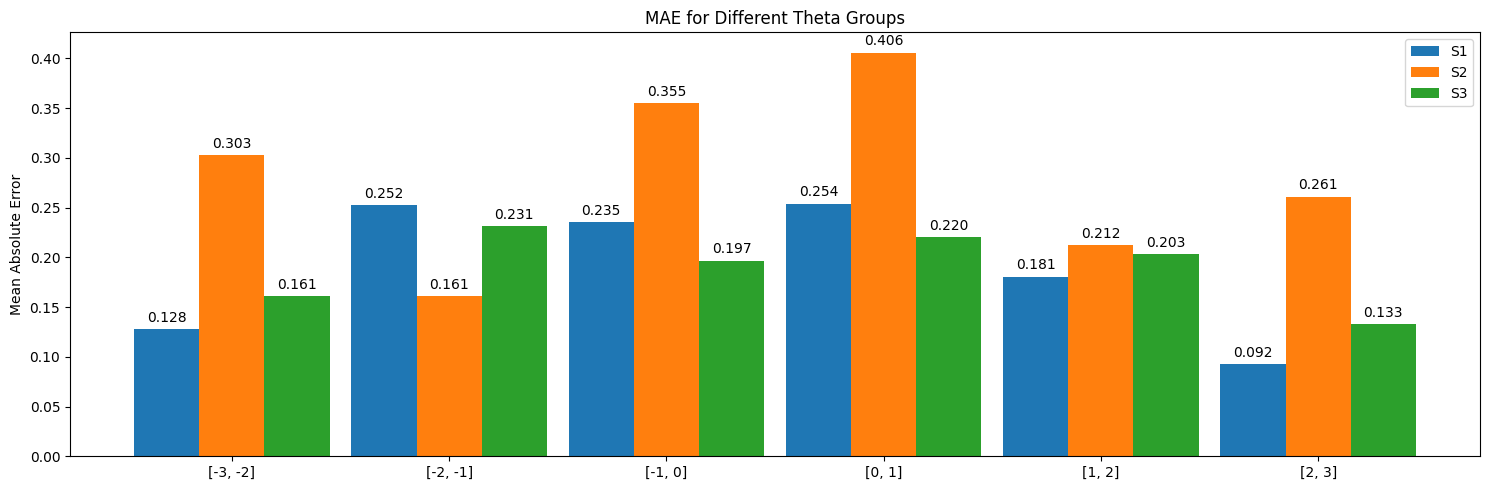

In [145]:
labels = ['[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]']
s1_mae = [np.mean(abs_e[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s2_mae = [np.mean(abs_e[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s3_mae = [np.mean(abs_e[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_mae, width, label='S1')
rects2 = ax.bar(x , s2_mae, width, label='S2')
rects3 = ax.bar(x + width, s3_mae, width, label='S3')

ax.set_title('MAE for Different Theta Groups')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.3f', padding=3)
ax.bar_label(rects2, fmt='%.3f', padding=3)
ax.bar_label(rects3, fmt='%.3f', padding=3)

fig.tight_layout()

## No. Questions 

The data suggests that the mean question count without the edge cases are $20.64028 ± 3.56094$. To maintain the low mean absolute error in the border sections, the model has to ask up to 90 questions to converge since there was no suitable questions with the appropriate difficulty $b$ value to accomodate. 

Mean Question Count:	20.64028 ± 3.56094
Mean Question Count Without Edges:	19.05096 ± 0.85060


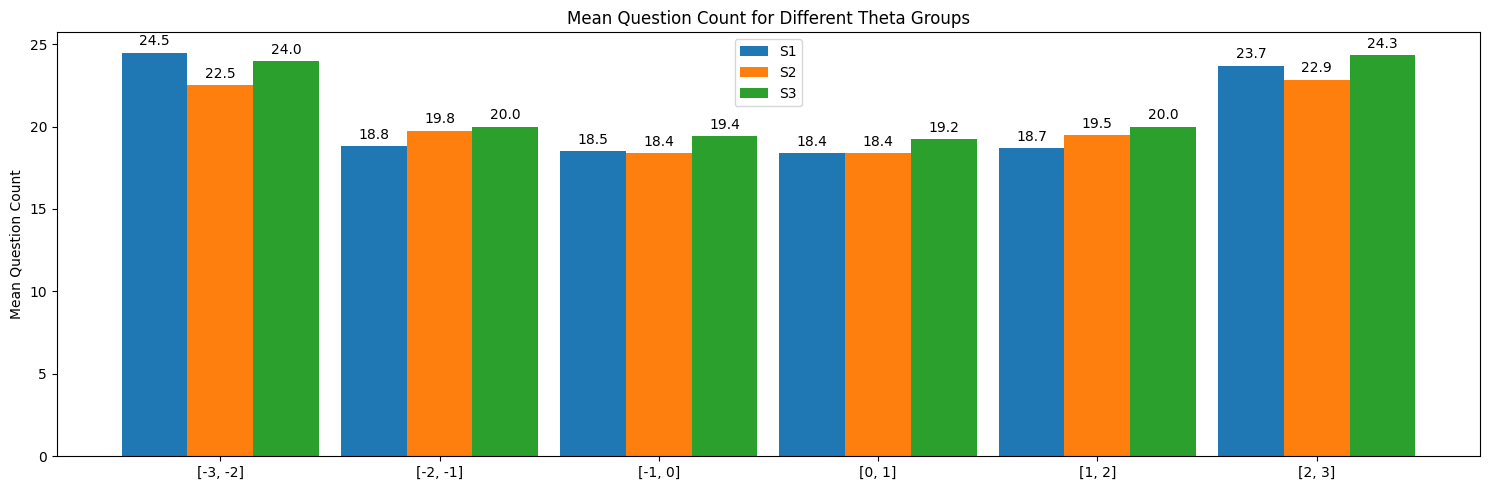

In [146]:
q_count = np.array([x["q_count"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
theta_real_list = np.array([x["theta_real"] for x in result_list])
q_count_mean = np.mean(q_count)
q_count_std = np.std(q_count)

print(f"Mean Question Count:\t{q_count_mean:.05f} ± {q_count_std:.05f}")
print(f"Mean Question Count Without Edges:\t{np.mean(q_count[(theta_real_list >= -2) & (theta_real_list <= 2)]):.05f} ± {np.std(q_count[(theta_real_list >= -2) & (theta_real_list <= 2)]):.05f}")

labels = ['[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]']
s1_q_count = [np.mean(q_count[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s2_q_count = [np.mean(q_count[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s3_q_count = [np.mean(q_count[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_q_count, width, label='S1')
rects2 = ax.bar(x , s2_q_count, width, label='S2')
rects3 = ax.bar(x + width, s3_q_count, width, label='S3')

ax.set_title('Mean Question Count for Different Theta Groups')
ax.set_ylabel('Mean Question Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.1f', padding=3)
ax.bar_label(rects2, fmt='%.1f', padding=3)
ax.bar_label(rects3, fmt='%.1f', padding=3)

fig.tight_layout()

## Number of Iterations per Optimization Step

Mean Iterations:	2.00390 ± 0.83582


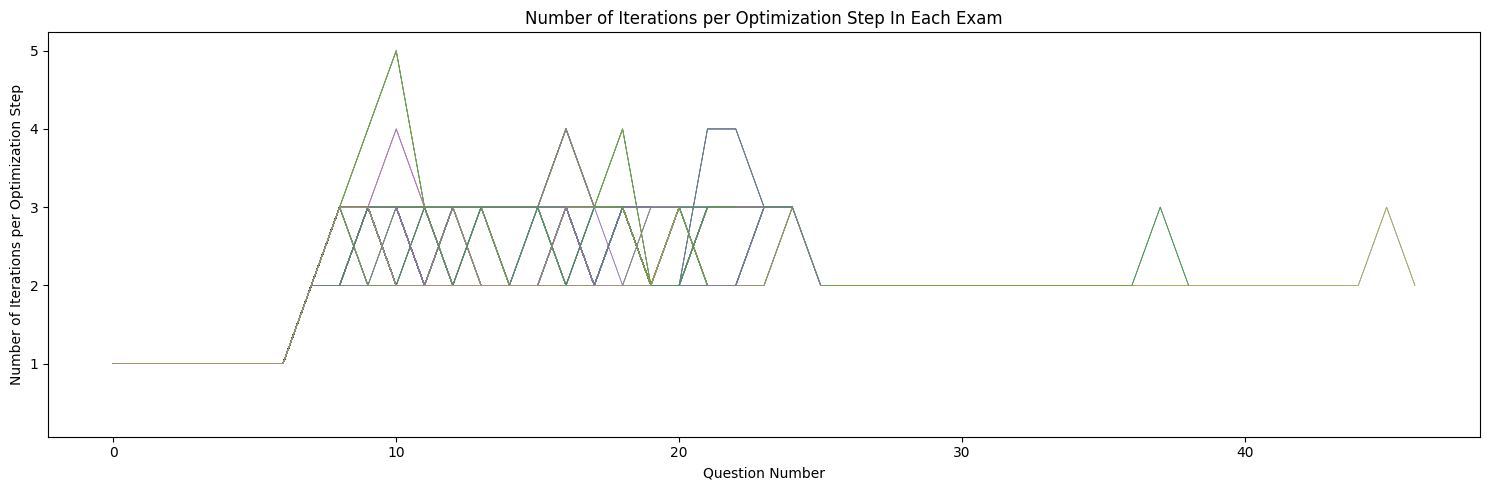

In [147]:
niter_list = [x["niter_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

niter_list_mean = np.mean(np.concatenate(niter_list))
niter_list_std = np.std(np.concatenate(niter_list))

print(f"Mean Iterations:\t{niter_list_mean:.05f} ± {niter_list_std:.05f}")

fig, ax = plt.subplots(1, figsize=(15,5))

for i, niter in enumerate(niter_list):
    x = np.arange(q_count[i])  
    ax.plot(x, niter, width, alpha=0.5, linewidth=0.5)

ax.set_title('Number of Iterations per Optimization Step In Each Exam')
ax.set_ylabel('Number of Iterations per Optimization Step')
ax.set_xlabel('Question Number')
# ax.set_ylim(0,100)

fig.tight_layout()

## Theta Convergence

Mean Theta:	-0.00389 ± 1.97314


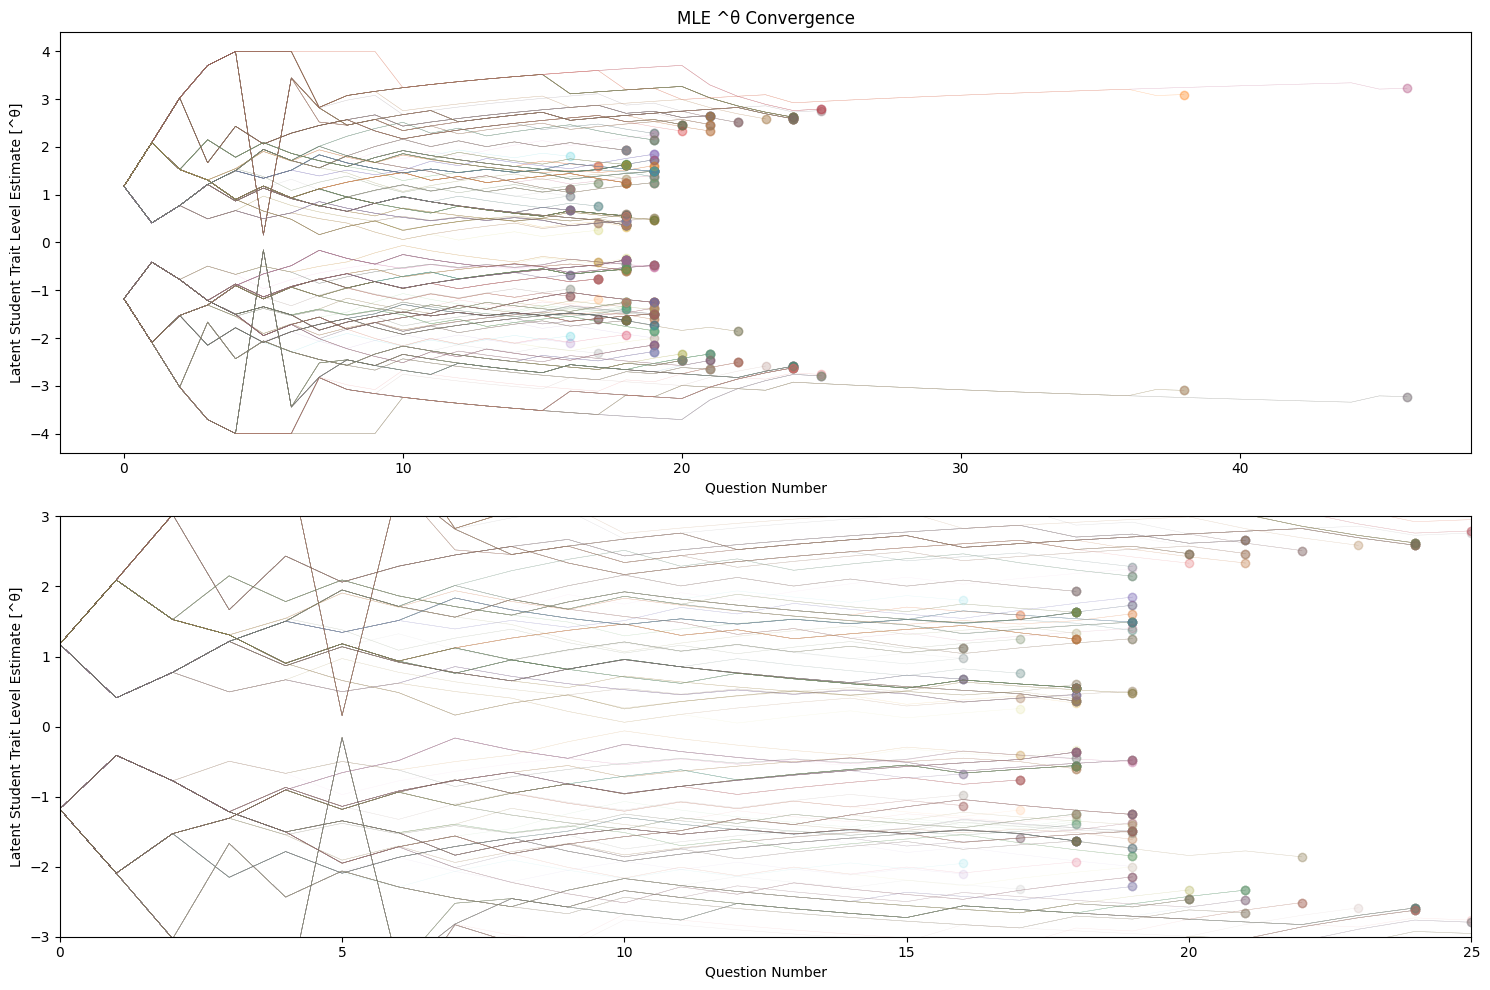

In [148]:
theta_list_list = [x["theta_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

theta_list_mean = np.mean(np.concatenate(theta_list_list))
theta_list_std = np.std(np.concatenate(theta_list_list))

print(f"Mean Theta:\t{theta_list_mean:.05f} ± {theta_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, theta_list, alpha=0.2, linewidth=0.3)# Mark end of the line
    ax1.scatter(x[-1], theta_list[-1], marker='o', alpha=0.2, linewidths=1.0, zorder=2)

ax1.set_title('MLE ^θ Convergence')
ax1.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, theta_list, '-', alpha=0.1, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], theta_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 25)
ax2.set_ylim(-3, 3)

fig.tight_layout()

## Difficulty Questions

Mean b:	0.00128 ± 1.57450


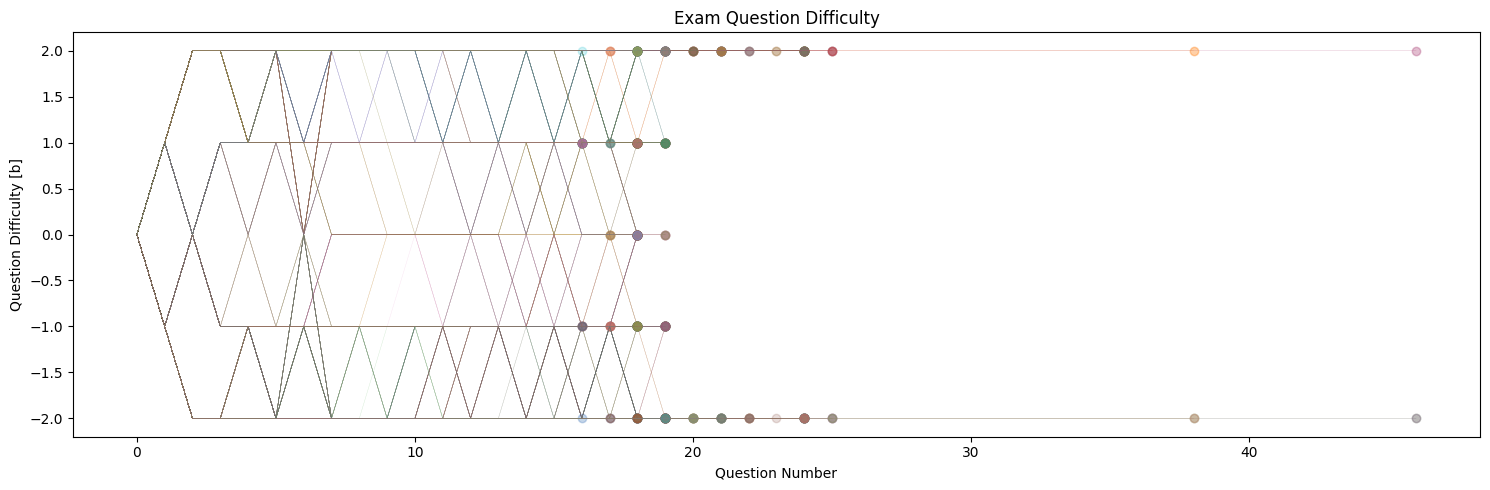

In [149]:
b_list_list = [x["b_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

b_list_mean = np.mean(np.concatenate(b_list_list))
b_list_std = np.std(np.concatenate(b_list_list))

print(f"Mean b:\t{b_list_mean:.05f} ± {b_list_std:.05f}")

fig, ax1  = plt.subplots(1, figsize=(15,5))

for i, b_list in enumerate(b_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, b_list, alpha=0.2, linewidth=0.3)# Mark end of the line
    ax1.scatter(x[-1], b_list[-1], marker='o', alpha=0.2, linewidths=1.0, zorder=2)

ax1.set_title('Exam Question Difficulty')
ax1.set_ylabel('Question Difficulty [b]')
ax1.set_xlabel('Question Number')


fig.tight_layout()

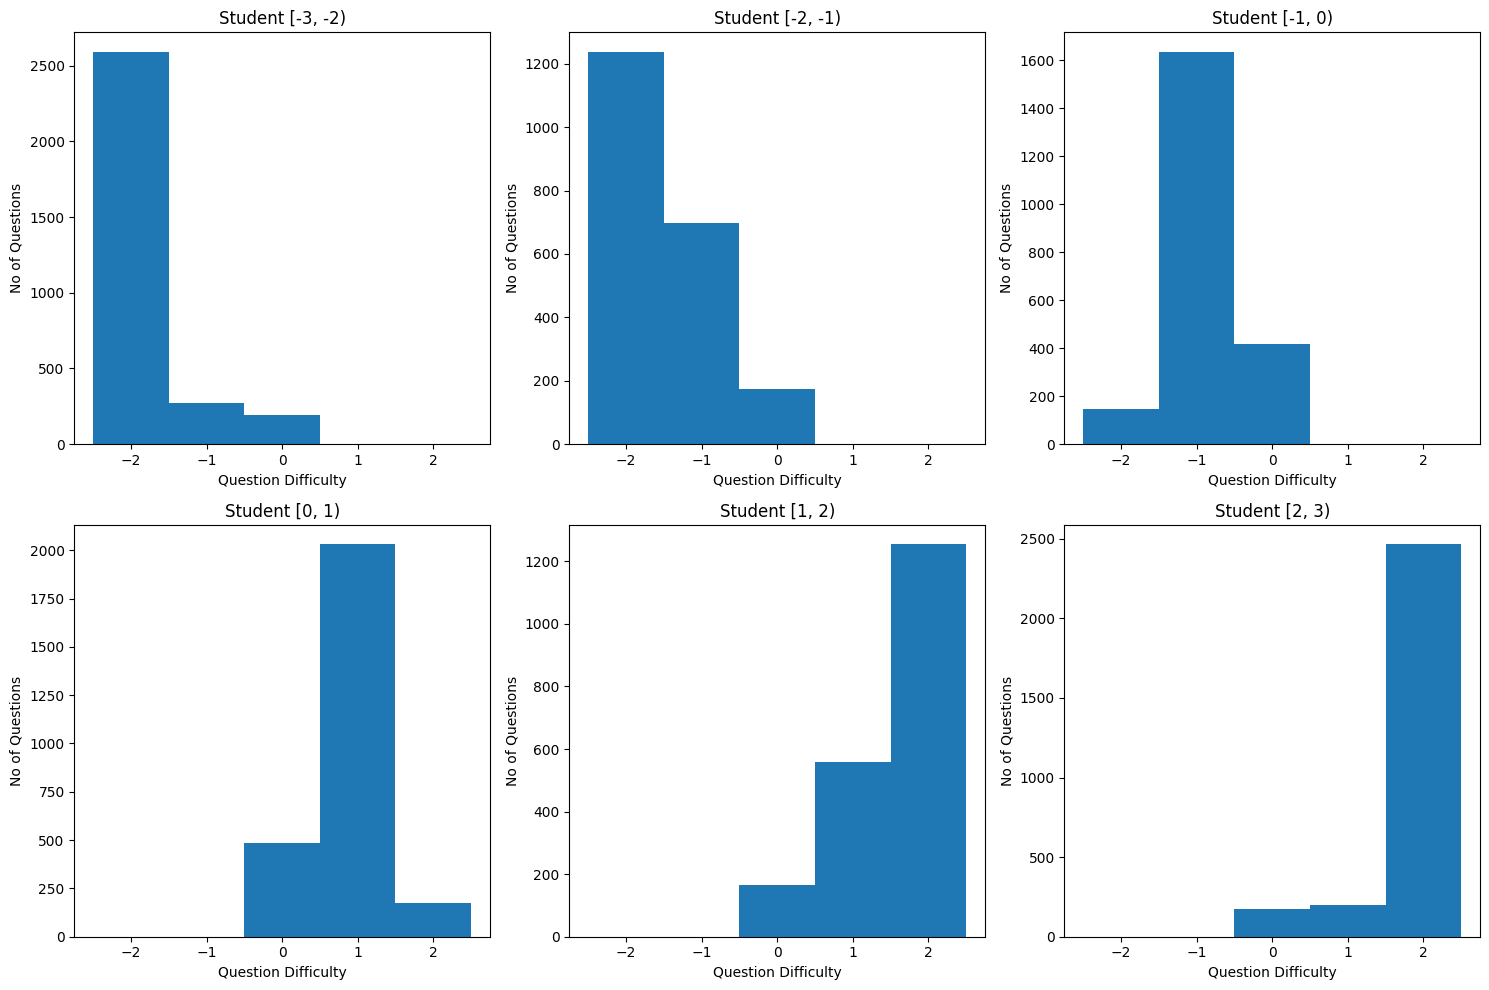

In [150]:
b_list_list = [x["b_list"] for x in result_list]
theta_real_list = np.array([x["theta_real"] for x in result_list])

# Distribution of b in each Student Level
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(5*3,5*2))
all_ax = [ax1,ax2,ax3,ax4,ax5,ax6]

for i,_theta in enumerate(range(-3, 3)):
    b_list = np.concatenate([xx for ii,xx in enumerate(b_list_list) if theta_real_list[ii] >= _theta and theta_real_list[ii] < _theta+1])
    # https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
    all_ax[i].hist(b_list, np.arange(-2.5, 2.5 + 1, 1))
    
    all_ax[i].set_title(f"Student [{_theta}, {_theta+1})")
    all_ax[i].set_ylabel(f"No of Questions")
    all_ax[i].set_xlabel(f"Question Difficulty")
    
    
fig.tight_layout()

## Standard Error Convergence

Mean Standard Error:	0.55328 ± 0.29804


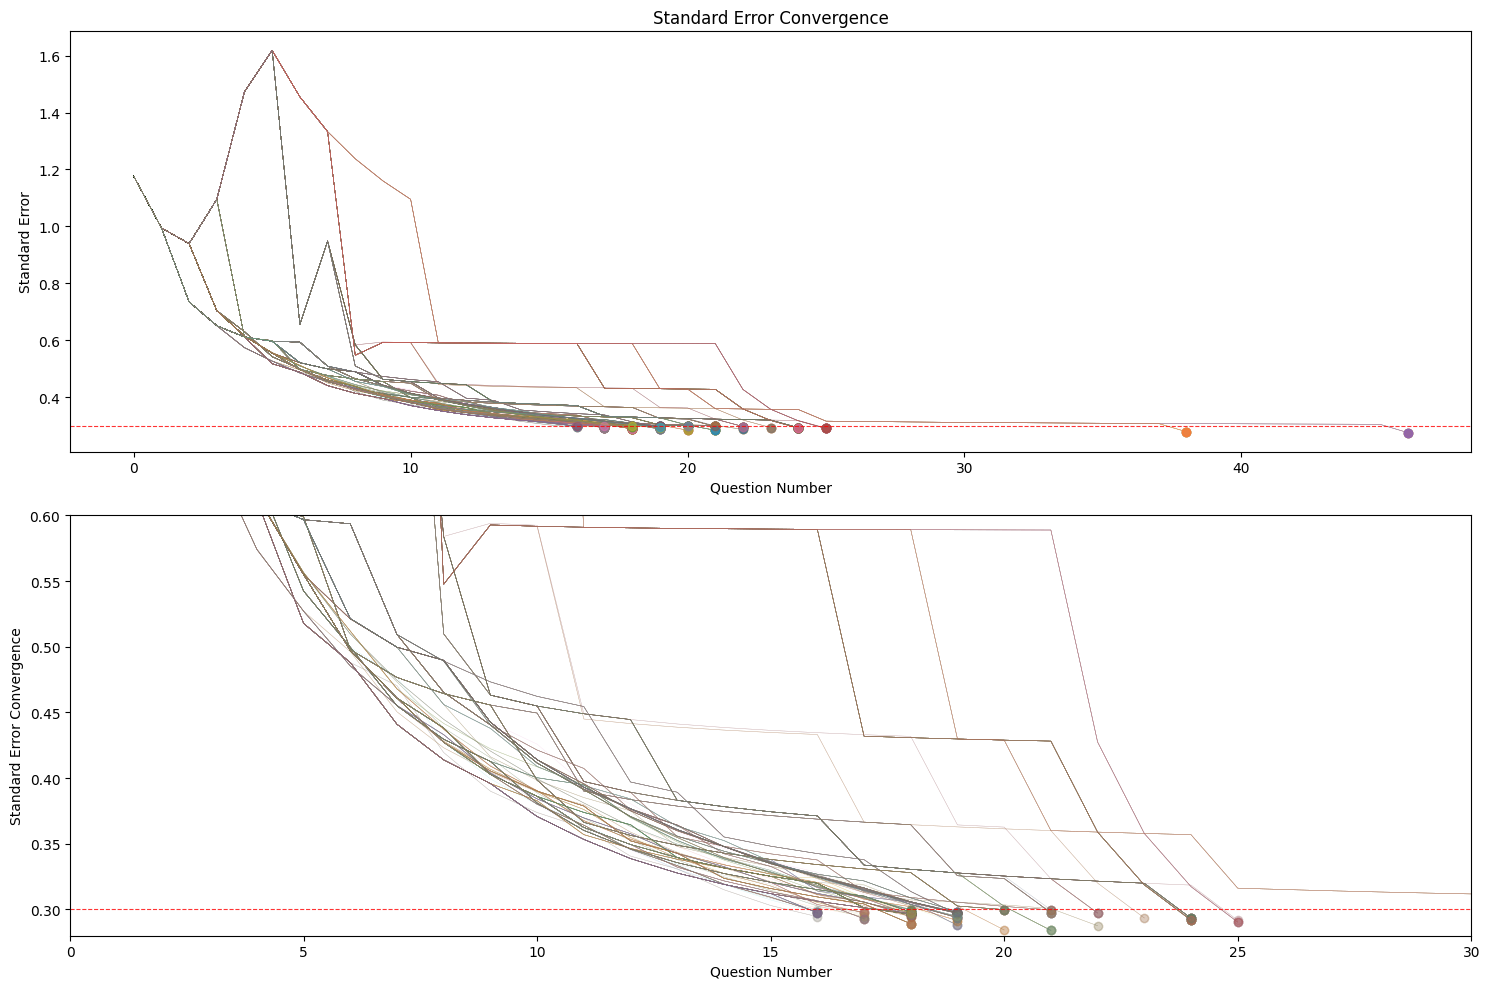

In [151]:
se_list_list = [x["se_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

se_list_mean = np.mean(np.concatenate(se_list_list))
se_list_std = np.std(np.concatenate(se_list_list))

print(f"Mean Standard Error:\t{se_list_mean:.05f} ± {se_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, se_list, alpha=0.4, linewidth=0.3)
    # Mark end of the line
    ax1.scatter(x[-1], se_list[-1], marker='o', alpha=0.5, linewidths=1.0, zorder=2)
ax1.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)

ax1.set_title('Standard Error Convergence')
ax1.set_ylabel('Standard Error')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, se_list, '-', alpha=0.2, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], se_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)
ax2.set_ylabel('Standard Error Convergence')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 30)
ax2.set_ylim(0.28, 0.6)

fig.tight_layout()

---

# Scenario 2: Sampling without Replacement

In [173]:
%%time
# Newton-Rhapson
MIN_Q_COUNT = 15
Q_START = 5 # The number of questions before starting optimize more than 1 iter

# This should be an object of a_list, b_list, u_list, theta_list, niter_list, se_list, converge_list
# [Scalar]: theta_final, theta_real, se_final, mae, q_count, seed
result_list = []

# For all Students
for theta_real in theta:
    # For all Seeds
    for seed in [123,1234,12345]:
        rng = np.random.default_rng(seed)
        
        t = 0
        q_count = 0
        std_err = 100

        a_list = np.array([])
        b_list = np.array([])
        u_list = np.array([])
        theta_list = []
        niter_list = []
        se_list = []
        converge_list = []
        
        a_copy = np.copy(a)
        b_copy = np.copy(b)
        is_exhaust = False

        while not (q_count >= MIN_Q_COUNT and std_err <= 0.3):
            if(b_copy.size <= 0): 
                is_exhaust = True
                break
            
            # All of the information in all the items
            items_info = fisher_information(a_copy,b_copy,t)
            # Find the indexes of the items with maximum information (have only 1 axis so [0])
            item_max_info_indexes = np.where(items_info==np.max(items_info))[0]
            # Select a random item from the max indexes
            item_index = rng.choice(item_max_info_indexes)

            # The question is a,b at item_index
            a_list = np.append(a_list, a_copy[item_index])
            b_list = np.append(b_list, b_copy[item_index])
            # Make Binomial Sampling with n=1 trial and p=probability matrix
            p = two_pl(a_copy[item_index],b_copy[item_index],theta_real)
            answer = rng.binomial(1, p)
            u_list = np.append(u_list, answer)

            df = get_d_log_likelihood_f(a_list, b_list, u_list)
            ddf = get_dd_log_likelihood_f(a_list, b_list, u_list)
            # Make maxiter max(q_count - 10, 1) to not get into diverging issues in the beginning 
            res = newton(df, t, fprime=ddf, full_output=True, tol=1e-03, maxiter= max(q_count - Q_START, 1), disp=False)
            std_err = np.sqrt(1/np.sum(fisher_information(a_list,b_list,t)))
            t = np.clip(res[0], -4, 4)

            theta_list.append(t)
            niter_list.append(res[1].iterations)
            se_list.append(std_err)
            converge_list.append(res[1].converged)
            
            # Remove Question from Pool
            a_copy = np.delete(a_copy,item_index)
            b_copy = np.delete(b_copy,item_index)
            
            q_count += 1
        result_list.append({
            "a_list": a_list,
            "b_list": b_list,
            "u_list": u_list,
            "theta_list": theta_list,
            "niter_list": niter_list,
            "se_list": se_list,
            "converge_list": converge_list,
            "theta_final": t,
            "theta_real": theta_real,
            "se_final": std_err,
            "mae": np.abs(t - theta_real),
            "q_count": q_count,
            "seed": seed,
            "is_exhaust": is_exhaust
        })

CPU times: user 11.8 s, sys: 11.9 ms, total: 11.8 s
Wall time: 11.8 s


In [179]:
len([x["is_exhaust"] for x in result_list if x["is_exhaust"] is True])

203

In [180]:
len([x["is_exhaust"] for x in result_list])

720

There are a total of **203 exams who runs out of question** (did all 61 questions before convergence) out of 720 total (~28%), which is not small considering uniform distribution of trait level from -3 to 3.

## Mean Absolute Error

Somehow MAE is not too bad at 0.27, even for exhaust conditions.

In [166]:
abs_e = np.array([x["mae"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
mae = np.mean(abs_e)
mae_std = np.std(abs_e)

print(f"Mean Absolute Error:\t{mae:.05f} ± {mae_std:.05f}")

print("MAE Per Category")
for seed in [123,1234,12345]:
    print(f"Seed: {seed}")
    abs_e_s = abs_e[seed_list==seed]
    # Draw Section lines for student ability 
    for level in range(-3, 3):
        _abs_e = abs_e_s[(theta >= level) & (theta <= level+1)]
        _mae = np.mean(_abs_e)
        _mae_std = np.std(_abs_e)
        print(f"θ [{level}, {level+1}]:\t{_mae:.05f} ± {_mae_std:.05f}")

Mean Absolute Error:	0.26934 ± 0.21722
MAE Per Category
Seed: 123
θ [-3, -2]:	0.32021 ± 0.19360
θ [-2, -1]:	0.22903 ± 0.12584
θ [-1, 0]:	0.13408 ± 0.10821
θ [0, 1]:	0.19463 ± 0.11178
θ [1, 2]:	0.28541 ± 0.16349
θ [2, 3]:	0.26433 ± 0.28719
Seed: 1234
θ [-3, -2]:	0.32143 ± 0.15892
θ [-2, -1]:	0.16112 ± 0.09776
θ [-1, 0]:	0.38893 ± 0.10557
θ [0, 1]:	0.22833 ± 0.22265
θ [1, 2]:	0.11027 ± 0.07022
θ [2, 3]:	0.33810 ± 0.25568
Seed: 12345
θ [-3, -2]:	0.51627 ± 0.36249
θ [-2, -1]:	0.23127 ± 0.10837
θ [-1, 0]:	0.16803 ± 0.13307
θ [0, 1]:	0.20418 ± 0.18286
θ [1, 2]:	0.20437 ± 0.10890
θ [2, 3]:	0.50525 ± 0.20577


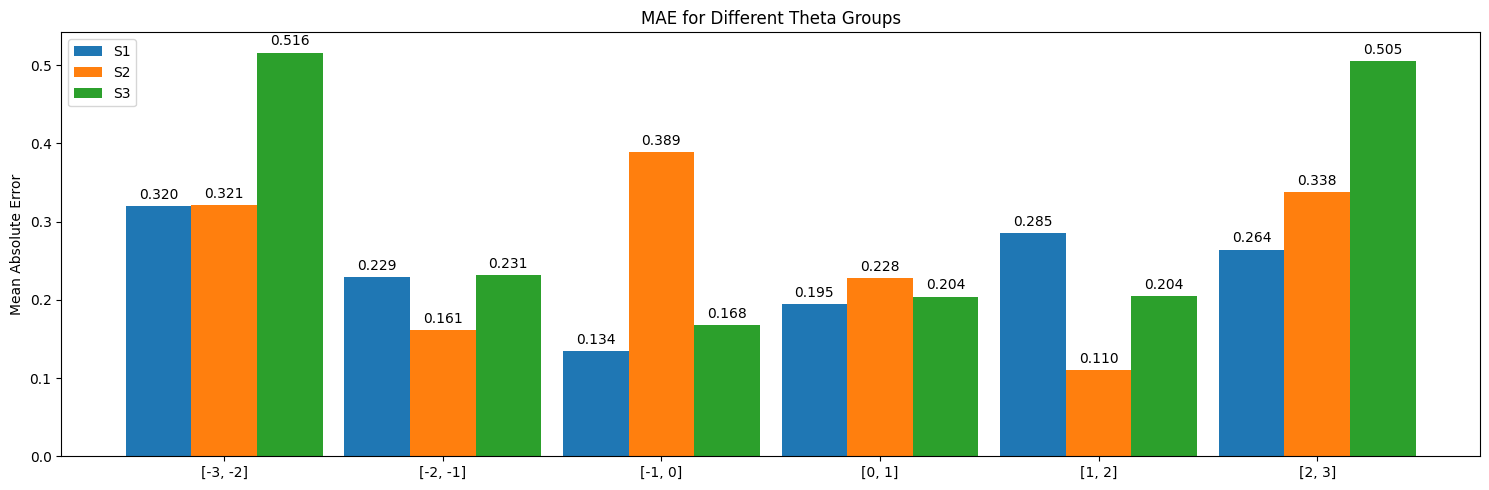

In [167]:
labels = ['[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]']
s1_mae = [np.mean(abs_e[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s2_mae = [np.mean(abs_e[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s3_mae = [np.mean(abs_e[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_mae, width, label='S1')
rects2 = ax.bar(x , s2_mae, width, label='S2')
rects3 = ax.bar(x + width, s3_mae, width, label='S3')

ax.set_title('MAE for Different Theta Groups')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.3f', padding=3)
ax.bar_label(rects2, fmt='%.3f', padding=3)
ax.bar_label(rects3, fmt='%.3f', padding=3)

fig.tight_layout()

## No. Questions

The number of questions increased a lot, from $19.05096$ to $32.56528$, a **71% increase**. Most of the increase comes from students at levels [1,3]. People who are at [2,3] almost always will NOT converge.

Mean Question Count:	32.56528 ± 18.03395
Mean Question Count Without Edges:	32.56528 ± 12.22277


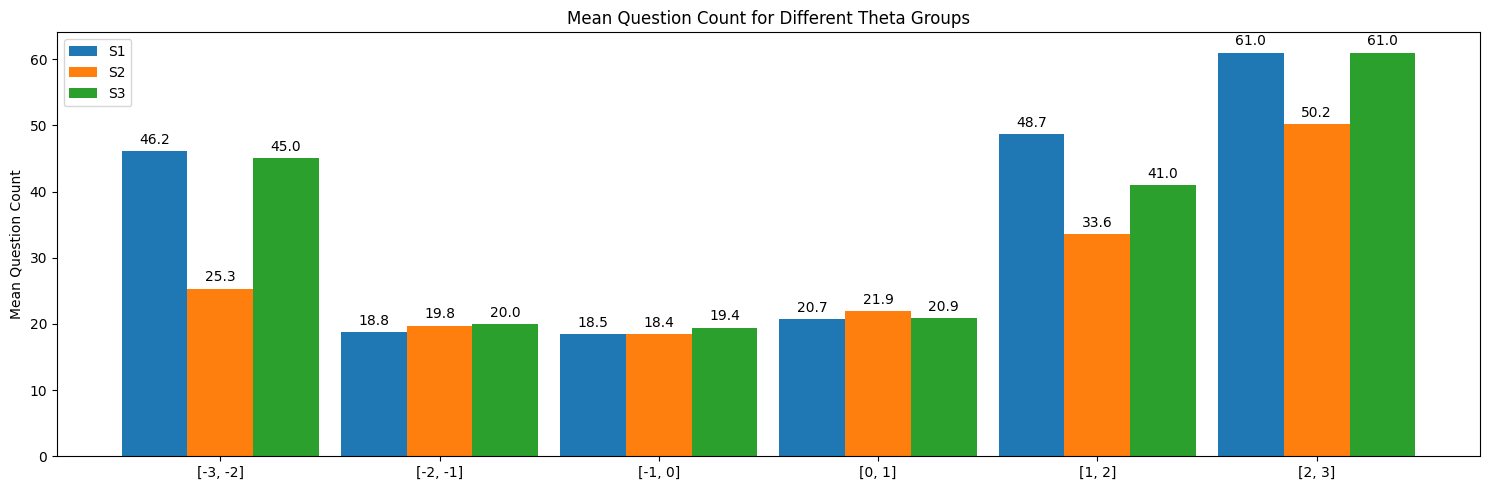

In [182]:
q_count = np.array([x["q_count"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
theta_real_list = np.array([x["theta_real"] for x in result_list])
q_count_mean = np.mean(q_count)
q_count_std = np.std(q_count)

print(f"Mean Question Count:\t{q_count_mean:.05f} ± {q_count_std:.05f}")
print(f"Mean Question Count Without Edges:\t{np.mean(q_count[(theta_real_list >= -3) & (theta_real_list <= 3)]):.05f} ± {np.std(q_count[(theta_real_list >= -2) & (theta_real_list <= 2)]):.05f}")

labels = ['[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]']
s1_q_count = [np.mean(q_count[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s2_q_count = [np.mean(q_count[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]
s3_q_count = [np.mean(q_count[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-3, 3) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_q_count, width, label='S1')
rects2 = ax.bar(x , s2_q_count, width, label='S2')
rects3 = ax.bar(x + width, s3_q_count, width, label='S3')

ax.set_title('Mean Question Count for Different Theta Groups')
ax.set_ylabel('Mean Question Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.1f', padding=3)
ax.bar_label(rects2, fmt='%.1f', padding=3)
ax.bar_label(rects3, fmt='%.1f', padding=3)

fig.tight_layout()

## Theta Convergence

It's surprising that there's also divergence at the bottom too, although not as much as the top.

Mean Theta:	0.41924 ± 2.23916


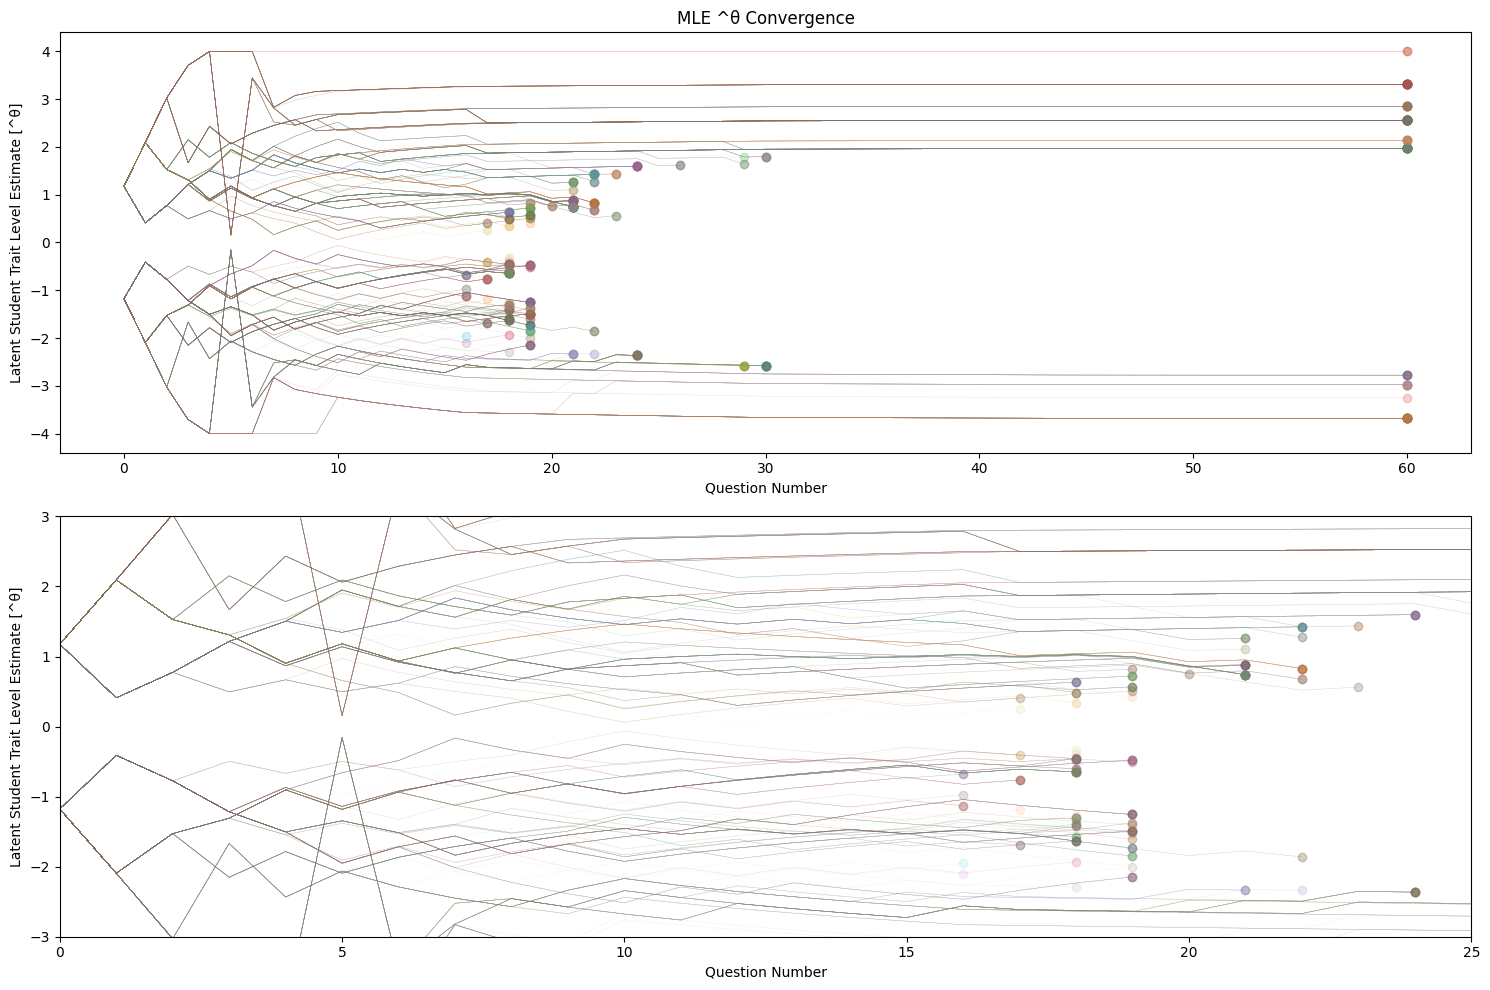

In [168]:
theta_list_list = [x["theta_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

theta_list_mean = np.mean(np.concatenate(theta_list_list))
theta_list_std = np.std(np.concatenate(theta_list_list))

print(f"Mean Theta:\t{theta_list_mean:.05f} ± {theta_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, theta_list, alpha=0.2, linewidth=0.3)# Mark end of the line
    ax1.scatter(x[-1], theta_list[-1], marker='o', alpha=0.2, linewidths=1.0, zorder=2)

ax1.set_title('MLE ^θ Convergence')
ax1.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, theta_list, '-', alpha=0.1, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], theta_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 25)
ax2.set_ylim(-3, 3)

fig.tight_layout()

## Difficulty Questions

We can see the divergence are mostly caused by 2 main lines, being exhaustion from the top or bottom.

In the histogram, now we see more distribution of the bottom questions in top students.

Mean b:	-0.36508 ± 1.28988


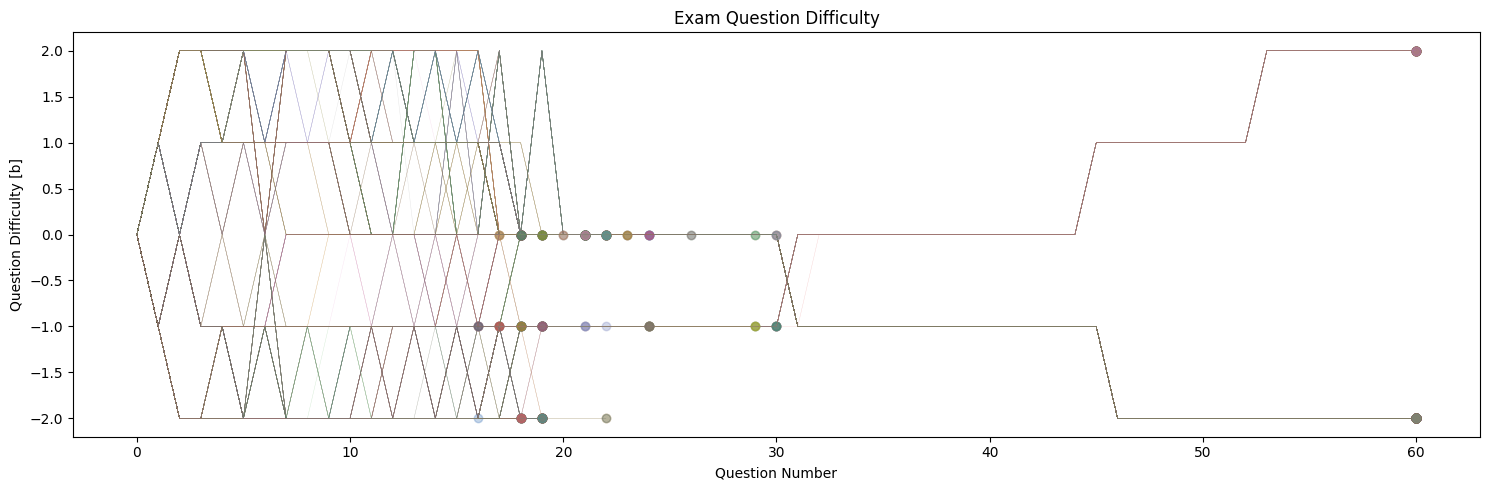

In [170]:
b_list_list = [x["b_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

b_list_mean = np.mean(np.concatenate(b_list_list))
b_list_std = np.std(np.concatenate(b_list_list))

print(f"Mean b:\t{b_list_mean:.05f} ± {b_list_std:.05f}")

fig, ax1  = plt.subplots(1, figsize=(15,5))

for i, b_list in enumerate(b_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, b_list, alpha=0.2, linewidth=0.3)# Mark end of the line
    ax1.scatter(x[-1], b_list[-1], marker='o', alpha=0.2, linewidths=1.0, zorder=2)

ax1.set_title('Exam Question Difficulty')
ax1.set_ylabel('Question Difficulty [b]')
ax1.set_xlabel('Question Number')


fig.tight_layout()

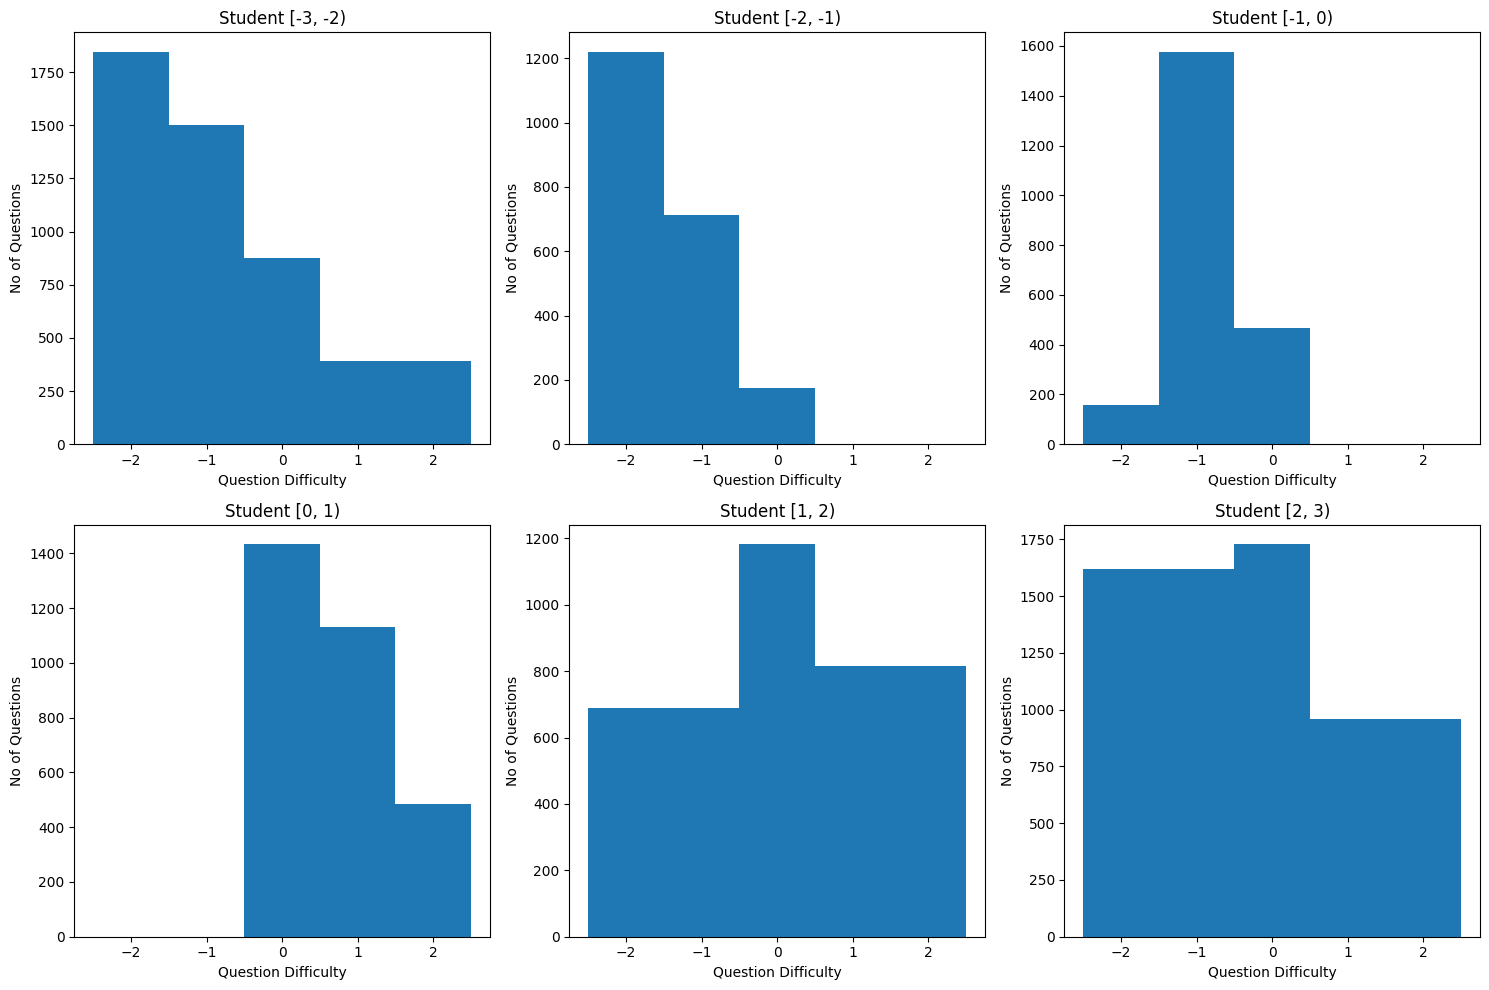

In [171]:
b_list_list = [x["b_list"] for x in result_list]
theta_real_list = np.array([x["theta_real"] for x in result_list])

# Distribution of b in each Student Level
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(5*3,5*2))
all_ax = [ax1,ax2,ax3,ax4,ax5,ax6]

for i,_theta in enumerate(range(-3, 3)):
    b_list = np.concatenate([xx for ii,xx in enumerate(b_list_list) if theta_real_list[ii] >= _theta and theta_real_list[ii] < _theta+1])
    # https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
    all_ax[i].hist(b_list, np.arange(-2.5, 2.5 + 1, 1))
    
    all_ax[i].set_title(f"Student [{_theta}, {_theta+1})")
    all_ax[i].set_ylabel(f"No of Questions")
    all_ax[i].set_xlabel(f"Question Difficulty")
    
    
fig.tight_layout()

## Standard Error Convergence

Standard error pretty much stays high for cases that exhaustion occurs.

Mean Standard Error:	0.51656 ± 0.25832


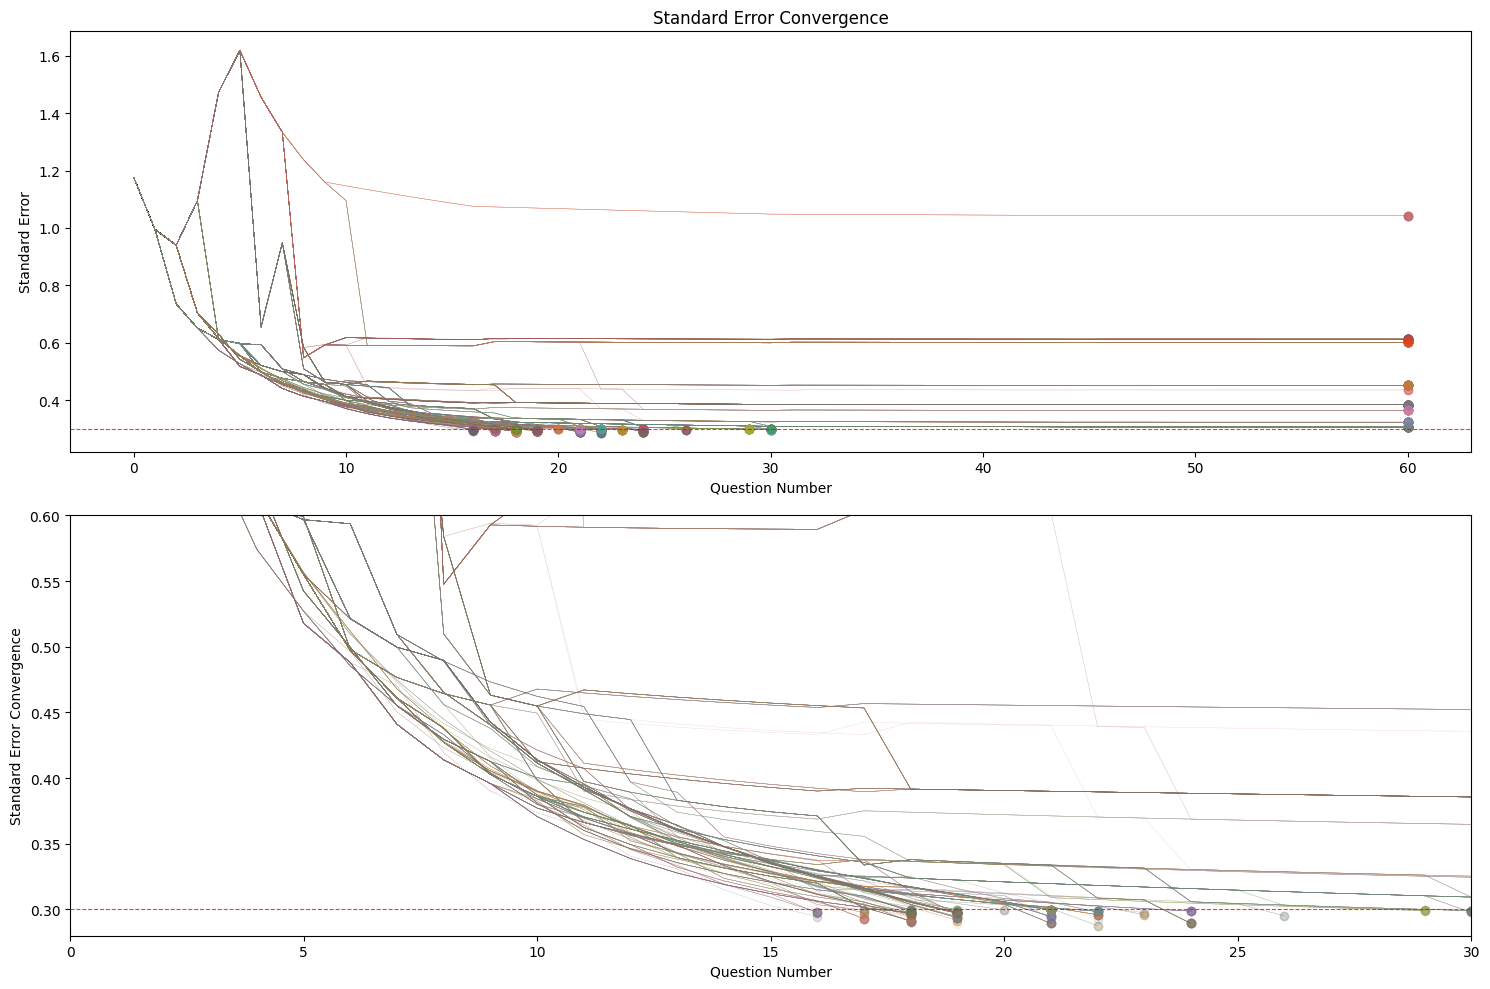

In [172]:
se_list_list = [x["se_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

se_list_mean = np.mean(np.concatenate(se_list_list))
se_list_std = np.std(np.concatenate(se_list_list))

print(f"Mean Standard Error:\t{se_list_mean:.05f} ± {se_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, se_list, alpha=0.4, linewidth=0.3)
    # Mark end of the line
    ax1.scatter(x[-1], se_list[-1], marker='o', alpha=0.5, linewidths=1.0, zorder=2)
ax1.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)

ax1.set_title('Standard Error Convergence')
ax1.set_ylabel('Standard Error')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, se_list, '-', alpha=0.2, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], se_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)
ax2.set_ylabel('Standard Error Convergence')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 30)
ax2.set_ylim(0.28, 0.6)

fig.tight_layout()